In [174]:
# Step 0a: Load packages

# Import the xarray package
import xarray as xr
# Iport the numpy package
import numpy as np
# Import the math package
import math
# Import the module pyplot from the package matplotlib
import matplotlib.pyplot as plt
# Import the package os (operating system interface).
import os
# Import the cartopy package for plotting the coastline
import cartopy.crs as ccrs
# Import features of cartopy for plotting country borders
import cartopy.feature as cf
# Import datetime package for temporal interpolation
import pandas as pd
# Import widgets for interactive usage
import ipywidgets as ipyw
from IPython.display import display

import glob
import numpy.ma as ma
import h5py
from datetime import datetime, timedelta
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as PathEffects
import matplotlib.colors as mcolors
from itertools import groupby
from operator import itemgetter
import matplotlib.ticker as ticker
import warnings

warnings.filterwarnings("ignore")



# Import intake package
import intake
# Import easy gems with healpix
from easygems import healpix as egh

In [175]:
pathEarthCare = '/work/bb1153/b309296/Data/EarthCare_ESA/CPR_CLD_2A/2025/04/'
file = "ECA_EXAB_CPR_CLD_2A_20250430T235936Z_20250501T014055Z_05244E.h5"
cld_file_path = pathEarthCare+file

INVALID_VALUE = 9.96920997e36
INVALID_THRESHOLD = 1e30

ORBIT_ID = "05244E"

def list_cld_variables_and_units(cld_file_path):
    """
    Print all variable names and units from a C-CLD file.
    """
    print(f"\nScanning CLD file: {cld_file_path}")
    try:
        with h5py.File(cld_file_path, "r") as f:

            def print_attrs(name, obj):
                if isinstance(obj, h5py.Dataset):
                    unit = obj.attrs.get("units", "(no unit)")
                    if isinstance(unit, bytes):
                        unit = unit.decode()
                    print(f"{name:50} — {unit}")

            f.visititems(print_attrs)
            land = f["ScienceData/land_flag"][:]
            print(land)
            
    except Exception as e:
        print(f"Failed to read file: {e}")

def find_cld_files(orbit_id, cld_dir):
    """Return sorted list of CLD files containing orbit_id in their name."""
    pattern = os.path.join(cld_dir, f"*{orbit_id}*.h5")
    files = sorted(glob.glob(pattern))
    return files

list_cld_variables_and_units(cld_file_path)


Scanning CLD file: /work/bb1153/b309296/Data/EarthCare_ESA/CPR_CLD_2A/2025/04/ECA_EXAB_CPR_CLD_2A_20250430T235936Z_20250501T014055Z_05244E.h5
HeaderData/FixedProductHeader/File_Class           — (no unit)
HeaderData/FixedProductHeader/File_Description     — (no unit)
HeaderData/FixedProductHeader/File_Name            — (no unit)
HeaderData/FixedProductHeader/File_Type            — (no unit)
HeaderData/FixedProductHeader/File_Version         — (no unit)
HeaderData/FixedProductHeader/Mission              — (no unit)
HeaderData/FixedProductHeader/Notes                — (no unit)
HeaderData/FixedProductHeader/Source/Creation_Date — (no unit)
HeaderData/FixedProductHeader/Source/Creator       — (no unit)
HeaderData/FixedProductHeader/Source/Creator_Version — (no unit)
HeaderData/FixedProductHeader/Source/System        — (no unit)
HeaderData/FixedProductHeader/Validity_Period/Validity_Start — (no unit)
HeaderData/FixedProductHeader/Validity_Period/Validity_Stop — (no unit)
HeaderData/Variab

In [176]:
def stitch_c_pro(cld_paths):

    # Allow both a single file path or a list of paths
    if isinstance(cld_paths, str):
        cld_paths = [cld_paths]
        
    """Read reflectivity and Doppler velocity arrays from one FMR, CD, and CLD files."""
    
    lat_list = []
    lon_list = []
    time_list = []
    height_list = []
    selev_list = []
    land_list = []
    lwc_list = []
    lreff_list = []
    wc_list = []
    lwp_list = []
    iwp_list = []
    rwp_list = []
    class_list = []
    frame_list = []

    for cld_path in cld_paths:
        with (
            h5py.File(cld_path, "r") as cf,
        ):
            # Groups
            cld_grp = cf["ScienceData"]
            # Coordinates
            lat = cld_grp["latitude"][:]
            lon = cld_grp["longitude"][:]
            time_sec = cld_grp["time"][:]
            height = cld_grp["height"][:]
            height = np.where(height > INVALID_THRESHOLD, 0.0, height) / 1000.0
            # Convert to datetime
            time_arr = np.array(
                [
                    datetime(2000, 1, 1) + timedelta(seconds=float(t))
                    for t in time_sec
                ]
            )
            lwc = cld_grp["liquid_water_content"][:]
            selev = cld_grp["surface_elevation"][:]
            land = cld_grp["land_flag"][:]
            lreff = cld_grp["liquid_effective_radius"][:]
            wc = cld_grp["water_content"][:]
            lwp = cld_grp["liquid_water_path"][:]
            iwp = cld_grp["ice_water_path"][:]
            rwp = cld_grp["rain_water_path"][:]
            hydclass = cld_grp["hydrometeor_classification"][:]

            fname = os.path.basename(cld_path)
            parts = fname.split("_")
            frame_code = parts[7][5]  # e.g., '04951A' → 'A'
            frame_arr = np.array([frame_code] * lwc.shape[0])

            # append everything
            lat_list.append(lat)
            lon_list.append(lon)
            time_list.append(np.array(time_arr, dtype="datetime64[ns]"))
            height_list.append(height)
            selev_list.append(selev)
            land_list.append(land)
            lwc_list.append(lwc)
            lreff_list.append(lreff)
            wc_list.append(wc)
            lwp_list.append(lwp)
            iwp_list.append(iwp)
            rwp_list.append(rwp)
            class_list.append(hydclass)
            frame_list.append(frame_arr)

    return {
        "latitude": np.concatenate(lat_list),
        "longitude": np.concatenate(lon_list),
        "time": np.concatenate(time_list),
        "height": np.concatenate(height_list),
        "surface_elevation": np.concatenate(selev_list),
        "land_flag": np.concatenate(land_list),
        "liquid_water_content": np.concatenate(lwc_list),
        "liquid_effective_radius": np.concatenate(lreff_list),
        "water_content": np.concatenate(wc_list),
        "liquid_water_path": np.concatenate(lwp_list),
        "ice_water_path": np.concatenate(iwp_list),
        "rain_water_path": np.concatenate(rwp_list),
        "hydrometeor_classification": np.concatenate(class_list),
        "frame": np.concatenate(frame_list),
    }

In [177]:
def readPath(fileName):

    filePath = pathEarthCare + fileName

    print(filePath)

    result = stitch_c_pro(filePath)

    lat = result["latitude"]
    lon = result["longitude"]

    return lon, lat

In [178]:
def plotEarthCarePath(lon, lat):
    # Set up a figure with Plate Carrée (rectangular) projection
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add features: coastlines, borders, etc.
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True)

    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)

    # Add a title
    plt.title('EarthCare path')

    # Plot the points
    ax.plot(lon, lat, 'ro', markersize=5, transform=ccrs.PlateCarree())

    print(lon)
    print(lat)
    
    # Show the plot
    plt.show()

In [179]:
def compute_alongtrack(lat, lon):
    """Dummy along-track distance function (real one uses haversine)."""
    return np.arange(len(lat)) * 1.0  # placeholder: 1 km spacing

def plot_water_content_from_result(result):
    #refl = result["reflectivity_corrected"]
    lwc = result["liquid_water_content"]  # kg/m3
    lreff = result["liquid_effective_radius"]  # m
    lwp = result["liquid_water_path"]  # kg/m2
    wc = result["water_content"]  # kg/m3
    rwp = result["rain_water_path"]  # kg/m2
    iwp = result["ice_water_path"]  # kg/m2
    hydclass = result["hydrometeor_classification"]
    height = result["height"]
    lat = result["latitude"]
    lon = result["longitude"]
    selev = result["surface_elevation"] / 1000.0  # convert to km
    frame = result[
        "frame"
    ]  # e.g., array like ['A', 'A', 'A', ..., 'B', 'B', ...]

    wc_plot = wc.astype(float)
    #refl_plot = refl.astype(float)
    mask_invalid = wc_plot > INVALID_THRESHOLD
    #mask_weak = refl_plot < -35
    #wc_plot[mask_invalid | mask_weak] = np.nan
    wc_plot[mask_invalid] = np.nan

    hydclass_plot = hydclass.astype(float)
    mask_invalid = hydclass_plot > INVALID_THRESHOLD
    hydclass_plot[mask_invalid] = np.nan

    # Along-track distance
    x_km = compute_alongtrack(lat, lon)
    x_mesh = np.tile(x_km[:, np.newaxis], (1, height.shape[1]))

    # Figure Water content
    fig, ax1 = plt.subplots(figsize=(10, 5))

    pcm1 = ax1.pcolormesh(
        x_mesh,
        height,
        wc_plot,
        cmap="YlGnBu",
        shading="auto",
        vmin=1e-7,
        vmax=1e-4,
    )
    for i in range(len(x_km) - 1):
        ax1.fill(
            [x_km[i], x_km[i + 1], x_km[i + 1], x_km[i]],
            [0, 0, selev[i + 1], selev[i]],
            color="lightgray",
            alpha=0.5,
        )
    ax1.set_ylim(0, 18)
    ax1.set_ylabel("Height (km)")
    ax1.set_title("Water Content (ice, snow, and rain)", fontsize=11)
    ax1.grid(True, linestyle="-", linewidth=0.35, alpha=0.4)
    cbar1 = plt.colorbar(pcm1, ax=ax1, pad=0.01, aspect=15)
    cbar1.set_label("(kg/m3)")
    y_bar = 17.5
 
    for spine in ax1.spines.values():
        spine.set_linewidth(1.5)



In [180]:
def plot_hydrometeor_classification_from_result(result):
    #refl = result["reflectivity_corrected"]
    lwc = result["liquid_water_content"]  # kg/m3
    lreff = result["liquid_effective_radius"]  # m
    lwp = result["liquid_water_path"]  # kg/m2
    wc = result["water_content"]  # kg/m3
    rwp = result["rain_water_path"]  # kg/m2
    iwp = result["ice_water_path"]  # kg/m2
    hydclass = result["hydrometeor_classification"]
    height = result["height"]
    lat = result["latitude"]
    lon = result["longitude"]
    selev = result["surface_elevation"] / 1000.0  # convert to km
    frame = result[
        "frame"
    ]  # e.g., array like ['A', 'A', 'A', ..., 'B', 'B', ...]

    wc_plot = wc.astype(float)
    #refl_plot = refl.astype(float)
    mask_invalid = wc_plot > INVALID_THRESHOLD
    #mask_weak = refl_plot < -35
    #wc_plot[mask_invalid | mask_weak] = np.nan
    wc_plot[mask_invalid] = np.nan

    hydclass_plot = hydclass.astype(float)
    mask_invalid = hydclass_plot > INVALID_THRESHOLD
    hydclass_plot[mask_invalid] = np.nan

    # Along-track distance
    x_km = compute_alongtrack(lat, lon)
    x_mesh = np.tile(x_km[:, np.newaxis], (1, height.shape[1]))

    # Hydrometeor Classification
    fig, ax2 = plt.subplots(figsize=(10, 5))

    # Set the classification range and corresponding colors (-1 to 20)
    bounds = np.arange(-1, 22)
    colors = [
        "#000000",
        "#a26640",
        "#ffffff",
        "#ffff8b",
        "#f5be26",
        "#f97415",
        "#ff000c",
        "#bf71fb",
        "#004576",
        "#0064f9",
        "#95d1fb",
        "#d7fffe",
        "#7b971d",
        "#840000",
        "#0205a7",
        "#840000",
        "#001145",
        "#bb3f3f",
        "#5684ad",
        "#eedc64",
        "#d8dcd6",
        "#c5c9c7",
    ]
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    pcm2 = ax2.pcolormesh(
        x_mesh, height, hydclass_plot, cmap=cmap, norm=norm, shading="auto"
    )
    for i in range(len(x_km) - 1):
        ax2.fill(
            [x_km[i], x_km[i + 1], x_km[i + 1], x_km[i]],
            [0, 0, selev[i + 1], selev[i]],
            color="lightgray",
            alpha=0.5,
        )
    ax2.set_ylim(0, 18)
    ax2.set_ylabel("Height (km)")
    ax2.set_xlabel("Along-track Distance (km)")
    ax2.set_title("Hydrometeor Classification", fontsize=11)
    ax2.grid(True, linestyle="-", linewidth=0.35, alpha=0.4)
    tick_positions = (bounds[:-1] + bounds[1:]) / 2
    cbar = plt.colorbar(
        pcm2, ax=ax2, orientation="vertical", pad=0.02, aspect=15
    )
    cbar.set_ticks(tick_positions)
    TC_name = [
        "missing data",
        "sub-surface",
        "clear",
        "liquid cloud",
        "drizzling liquid cloud",
        "warm rain",
        "cold rain",
        "melting snow",
        "rimed snow",
        "snow",
        "ice cloud",
        "stratospheric ice",
        "insects",
        "heavy rain likely",
        "heavy snow likely",
        "heavy rain",
        "heavy snow",
        "rain in clutter",
        "snow in clutter",
        "cloud in clutter",
        "clear in clutter",
        "uncertain",
    ]
    cbar.set_ticklabels([str(i) for i in TC_name[:]])
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.yaxis.set_minor_locator(ticker.NullLocator())

    for spine in ax2.spines.values():
        spine.set_linewidth(1.5)



In [181]:
def plotEarthCareData(fileName):
    outputB = ipyw.Output()

    filePath = pathEarthCare + fileName

    # Dropdown menu for plot selection
    dropdownB = ipyw.Dropdown(
        options=["water content", "hydrometeor classification"],
        value="water content",
        description='Plot selection:',
        style={'description_width': 'initial'},
        indent=False,
        layout=ipyw.Layout(width='35%', margin='30px 100px 30px 0px')
    )

    display(dropdownB)

    # Button click handler
    def on_buttonB_click(b):
        with outputB:
            outputB.clear_output()

            selection = dropdownB.value
            result = stitch_c_pro(filePath)

            if selection == "water content":
                plot_water_content_from_result(result)
            elif selection == "hydrometeor classification":
                plot_hydrometeor_classification_from_result(result)

    # Button to confirm selection
    buttonB = ipyw.Button(
        description="Confirm selection",
        layout=ipyw.Layout(margin='30px 0px 30px 0px')
    )
    buttonB.on_click(on_buttonB_click)


    display(buttonB)
    display(outputB)


Dropdown(description='Path selection:   ', layout=Layout(margin='30px 100px 30px 0px', width='35%'), options=(…

Button(description='Confirm selection', layout=Layout(margin='30px 0px 30px 0px'), style=ButtonStyle())

Output()

Output()

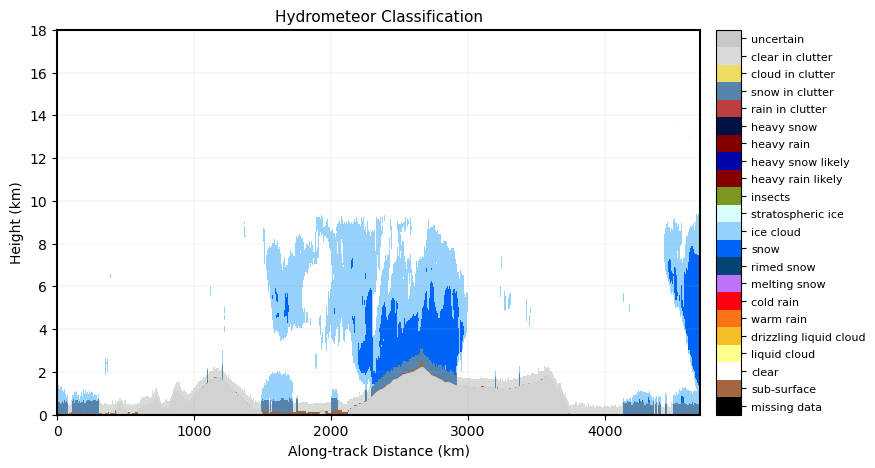

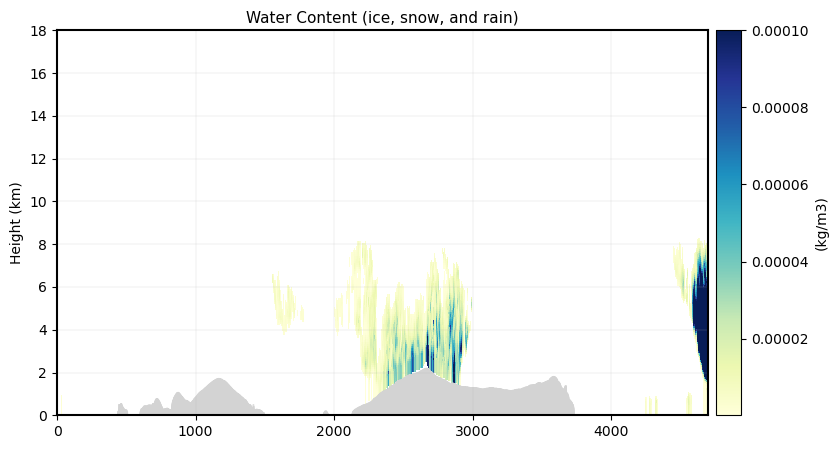

In [183]:
# Start the visualization script by filling out the basic setup
# Create an Output widget to display the results
outputA = ipyw.Output()

#######################################################################################################################
# Function to handle visualizations based on selections (is executed after pressing the button)
def on_buttonA_click(b):

    ###################################################################################################################
    # Continue only if the some selection was made in the dropdown menu
    with outputA:
        ###########################################################################################################
        # Retrieving the values from the widgets and store them in global variables
        pathFile = dropdown.value

        ###########################################################################################################
        # Clear previous outputs
        outputA.clear_output()

        ###########################################################################################################
        # Call the following function to continue with the setup

        #lonCoord, latCoord = readPath(pathFile)

        lon, lat = readPath(pathFile)
        plotEarthCarePath(lon, lat)

        plotEarthCareData(pathFile)
        

# List all files and folders
all_entries = os.listdir(pathEarthCare)

# Filter only files
files = [f for f in all_entries if os.path.isfile(os.path.join(pathEarthCare, f))]

dropdown = ipyw.Dropdown(
    options=files,
    description='Path selection:   ',
    style={'description_width': 'initial'},
    indent=False,
    layout=ipyw.Layout(width='35%', margin='30px 100px 30px 0px')
)

display(dropdown)

#######################################################################################################################
# Button to trigger computation
buttonA = ipyw.Button(description="Confirm selection", layout=ipyw.Layout(margin='30px 0px 30px 0px'))
buttonA.on_click(on_buttonA_click)

display(buttonA)

# Display the output widget to show the results
display(outputA)